In [140]:
# Imports
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [141]:
def build_dpg(A):
    # Diagonal degree matrix of A
    D = np.diag(np.sum(A, axis=0))

    # Transition probability matrix from scaling all adjacencies with 1/degree
    P = np.matmul(np.linalg.inv(D), A)

    # Create networkx graph from adjacency matrix
    G = nx.from_numpy_matrix(A, parallel_edges=True, create_using=nx.MultiGraph())

    return D, P, G

In [142]:
def calculate_pi(P):
    # approximate stationary distribution of Markov Chain
    return [round(x, 3) for x in list(np.linalg.matrix_power(P, 10000)[0])]

In [143]:
def graph_rw_sim(nsim, n, v0, P):
    # nsim different random walks of length n on G
    all_walks = []
    ps = P.shape[0]
    
    for _ in range(nsim):
        walk = np.zeros(n+1)
        walk[0] = v0

        current = v0-1
        for k in range(1, n+1):
            vk = np.random.choice(range(ps), 1, p=P[current])
            current = vk[0]
            walk[k] = current+1
    
        all_walks.append(walk)

    simulation_data = pd.DataFrame(all_walks).T
    return(simulation_data)

In [144]:
def plot_graph_rw_sim(data):
    plt.figure(figsize=(5, 5))
    plt.plot(data)
    plt.show()

In [145]:
def graph_rw_cover_time_sim(nsim, v0, P, G):
    # nsim cover times for random walk on G
    node_set = set(sorted(G.nodes()))
    all_cover_times = []
    ps = P.shape[0]

    for _ in range(nsim):
        current = v0-1
        done = False
        visited = [v0]
        k = 0
        while not done:
            vk = np.random.choice(range(ps), 1, p=P[current])
            current = vk[0]
            visited.append(current+1)

            if(node_set == set(sorted(visited))):
                done = True
            else:
                k+=1
    
        all_cover_times.append(k)
    return(all_cover_times)

In [146]:
def expected_cover_time_mc(data):
    # expected cover time based on Monte Carlo
    return np.mean(data)

In [147]:
def simple_update(k, pos, G, ax, rw_realization):
    # used for making a gif of a single random walk realization
    ax.clear()

    nx.draw_networkx(G, pos=pos, with_labels=True)
    nx.draw_networkx(G.subgraph(rw_realization[k]), pos=pos, node_color="red")
    
    ax.set_title("Time-step %d" % k)

In [148]:
def main():
    # Good Will Hunting problem adjacency matrix
    A = np.array([[0, 1, 0, 1], #1
                [1, 0, 2, 1], #2
                [0, 2, 0, 0], #3
                [1, 1, 0, 0]]) #4
    
    D, P, G = build_dpg(A)
    
    # Relabel vertices in accordance with paper
    mapping = {3:1, 0:4, 1:2, 2:3}
    G = nx.relabel_nodes(G, mapping)

    # Simulate
    v0 = np.random.choice(sorted(G.nodes()), p=[.25, .25, .25, .25])
    v0_pi = np.random.choice(sorted(G.nodes()), p=calculate_pi(P))

    NWALKS = 3
    WALKLEN = 60
    data = graph_rw_sim(NWALKS, WALKLEN, v0, P).astype(int)
    plot_graph_rw_sim(data)

    # Animated random walk realizations
    pos = nx.spring_layout(G)
    figure, axes = plt.subplots(figsize=(10, 10))

    for i, col in enumerate(data.columns):
        ani = animation.FuncAnimation(figure, simple_update, frames=WALKLEN+1, fargs=(pos, G, axes, data[col]))
        ani.save("./rw_animation_data/rw_realization" + str(i+1) + ".gif", writer="Pillow")

    # Cover time simulations
    NSIM=1000
    cover_time_data = graph_rw_cover_time_sim(NSIM, v0, P, G)
    cover_time_data_pi = graph_rw_cover_time_sim(NSIM, v0_pi, P, G)
    print("Expected cover time (random uniform start) is: %.2f" % expected_cover_time_mc(cover_time_data))
    print("Expected cover time (random stationary start) is: %.2f" % expected_cover_time_mc(cover_time_data_pi))

    # More simulations with random graphs
    G_complete = nx.complete_graph(10)
    G_lollipop = nx.lollipop_graph(5, 5)
    G_star = nx.star_graph(9)
    G_tree = nx.random_tree(10)
    G_regular = nx.random_regular_graph(5, 10)

    all_graphs = {"Complete":G_complete, "Lollipop":G_lollipop, "Star":G_star, "Tree":G_tree, "Regular":G_regular}
    for key in all_graphs.keys():
        all_graphs[key] = nx.convert_node_labels_to_integers(all_graphs[key], 1)
        
        A_rand = np.array(nx.adjacency_matrix(all_graphs[key]).todense())
        D_rand, P_rand, G_rand = build_dpg(A_rand)
        v0_rand = 1
        print("Expected cover time (", key, ") is: %.2f" % expected_cover_time_mc(graph_rw_cover_time_sim(NSIM, v0_rand, P_rand, all_graphs[key])))

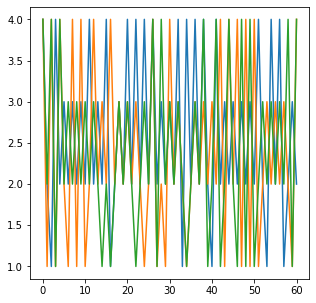

MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.
MovieWriter Pillow unavailable; using Pillow instead.


Expected cover time (random uniform start) is: 6.45
Expected cover time (random stationary start) is: 6.53
Expected cover time ( Complete ) is: 24.34
Expected cover time ( Lollipop ) is: 129.72
Expected cover time ( Star ) is: 49.17
Expected cover time ( Tree ) is: 74.49
Expected cover time ( Regular ) is: 27.88


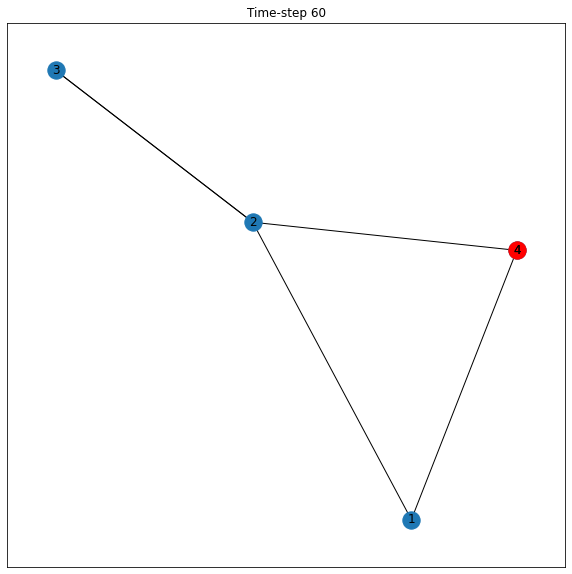

In [149]:
if __name__ == "__main__":
    main()